# Tutorial on **Image Classification Using Dino-v3**

## 1. Imports and Device

In [ ]:
!pip install timm==1.0.20 torchvision matplotlib scikit-learn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 164.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3

In [ ]:
import torch
import torch.nn as nn
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F

## 2 Data: CIFAR-10 setup

In [ ]:

transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_ds = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
val_ds = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
subset_size = 500
subset_indices = np.random.choice(len(val_ds), subset_size, replace=False)
val_subset = Subset(val_ds, subset_indices)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=4)
val_subset_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:05<00:00, 29.1MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


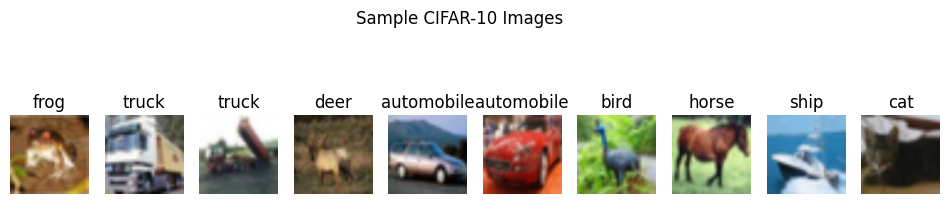

In [ ]:
classes = train_ds.classes
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
  img, label = train_ds[i]
  img_show = img.permute(1, 2, 0).numpy()
  img_show = np.clip((img_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]), 0, 1)
  axes[i].imshow(img_show)
  axes[i].set_title(classes[label])
  axes[i].axis('off')
plt.suptitle('Sample CIFAR-10 Images')
plt.show()

## 3 Model: timm DINOv3 backbone

In [ ]:

backbone_name = 'vit_base_patch16_dinov3'
backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0, global_pool='avg')


class DinoClassifier(nn.Module):
  def __init__(self, backbone, num_classes=10):
    super().__init__()
    self.backbone = backbone
    feat_dim = backbone.num_features
    self.head = nn.Linear(feat_dim, num_classes)


  def forward(self, x):
    x = self.backbone(x)
    x = self.head(x)
    return x


model = DinoClassifier(backbone, num_classes=10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
print(model)

DinoClassifier(
  (backbone): Eva(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (rope): RotaryEmbeddingDinoV3()
    (norm_pre): Identity()
    (blocks): ModuleList(
      (0-11): 12 x EvaBlock(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): EvaAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(app

**Image → Split into (16x16) patches →
  Patch Embedding (Conv2d, 768d)
      → Positional Encoding (RoPE)
      → 12 Transformer Layers (Feature Extraction)
      → Normalization
      → Classifier (Linear → 10 Classes)**

In [ ]:
# Freeze backbone for faster linear probing
for param in model.backbone.parameters():
  param.requires_grad = False

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)


def evaluate(model, loader, title):
  model.eval()
  all_preds, all_labels = [], []
  with torch.no_grad():
    for imgs, labels in loader:
      imgs, labels = imgs.to(device), labels.to(device)
      outputs = model(imgs)
      preds = outputs.argmax(dim=1)
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())
  cm = confusion_matrix(all_labels, all_preds, labels=list(range(10)))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot(xticks_rotation='vertical', cmap='Blues')
  plt.title(title)
  plt.show()
  acc = (np.array(all_preds) == np.array(all_labels)).mean()
  print(f"Accuracy: {acc*100:.2f}%\n")

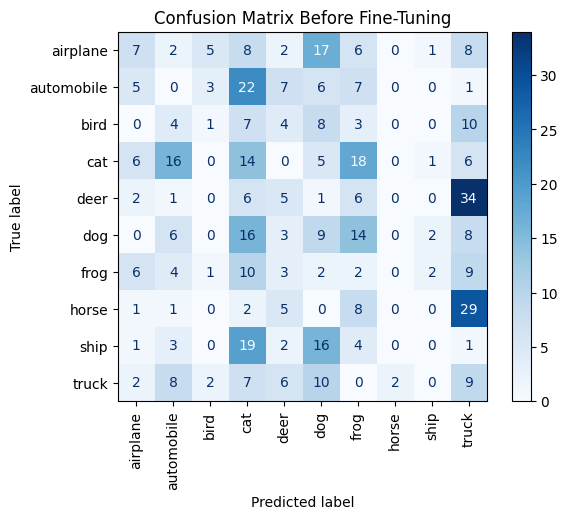

Accuracy: 9.40%



In [ ]:
# Evaluate before fine-tuning
evaluate(model, val_subset_loader, title='Confusion Matrix Before Fine-Tuning')

## 4 Training

In [ ]:
from tqdm import tqdm
EPOCHS = 2
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0
  progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]", leave=False, mininterval=3)
  for images, labels in progress_bar:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
print(f"Epoch [{epoch+1}/{EPOCHS}] - Avg Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/2]:   0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                                           

Epoch [2/2] - Avg Loss: 0.2984


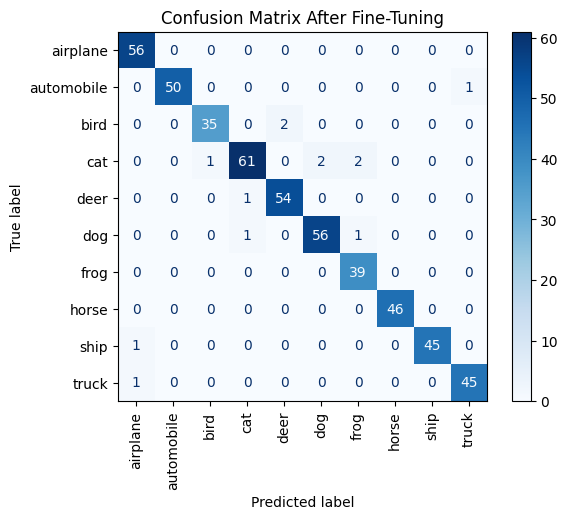

Accuracy: 97.40%



In [ ]:
evaluate(model, val_subset_loader, title='Confusion Matrix After Fine-Tuning')